In [1]:
import sqlite3
from functools import partial
from typing import List

import numpy as np
import pandas as pd
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    mutual_info_classif,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
def get_clf(best_params: dict):
    mutual_info_func = partial(mutual_info_classif, n_neighbors=5, random_state=42, n_jobs=-1)  # type: ignore
    params = {
        "penalty": "l2",
        "C": best_params["C"],
        "max_iter": 300,
        "random_state": 42,
    }
    estimator = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(**params)),
        ]
    )
    clf = Pipeline(
        steps=[
            ("var_threshold", VarianceThreshold(threshold=0.05)),
            (
                "mutual_info",
                SelectKBest(
                    score_func=mutual_info_func, k=best_params["k"]
                ),
            ),
            ("estimator", estimator),
        ]
    )

    return clf

def get_train_bout_ids(cutoff_year: int) -> List[str]:
    db_path = "../../data/ufc.db"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(
            """
            SELECT id
            FROM ufcstats_bouts
            WHERE event_id IN (
                SELECT id
                FROM ufcstats_events
                WHERE is_ufc_event = 1
                    AND date >= '2008-04-19'
                    AND date <= :cutoff_date
            ) AND red_outcome IN ('W', 'L');
            """,
            conn,
            params={
                "cutoff_date": f"{cutoff_year}-12-31",
            },
        )

    bout_ids = df["id"].tolist()

    return bout_ids

def get_backtest_year_metadata(cutoff_year: int) -> pd.DataFrame:
    db_path = "../../data/ufc.db"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(
            """
            SELECT t1.event_id, t1.id AS bout_id
            FROM ufcstats_bouts AS t1
            LEFT JOIN event_mapping AS t2 ON t1.event_id = t2.ufcstats_id
            WHERE t1.event_id IN (
                SELECT id
                FROM ufcstats_events
                WHERE is_ufc_event = 1
                    AND date >= :backtest_start_date
                    AND date <= :backtest_end_date
            )
            ORDER BY t2.wikipedia_id, t1.bout_order;
            """,
            conn,
            params={
                "backtest_start_date": f"{cutoff_year + 1}-01-01",
                "backtest_end_date": f"{cutoff_year + 1}-12-31",
            },
        )

    return df

def get_trainable_bouts_from_event(event_id: str) -> List[str]:
    db_path = "../../data/ufc.db"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(
            """
            SELECT id
            FROM ufcstats_bouts
            WHERE event_id = :event_id
                AND red_outcome IN ('W', 'L');
            """,
            conn,
            params={
                "event_id": event_id,
            },
        )

    bout_ids = df["id"].tolist()

    return bout_ids

In [3]:
# hyperparams = {
#     2016: {"k": 19, "C": 0.03264349605894313},
#     2017: {"k": 18, "C": 35.592264981991015},
#     2018: {"k": 32, "C": 0.018110333653021393},
#     2019: {"k": 69, "C": 0.01172059211805436},
#     2020: {"k": 19, "C": 1.1325507676814568},
#     2021: {"k": 73, "C": 0.011073372397562333},
#     2022: {"k": 80, "C": 0.016241472533695213},
#     2023: {"k": 61, "C": 0.05933246287126908},
# }
hyperparams = {
    2016: {"k": 21, "C": 0.05057388215089057},
    2017: {"k": 25, "C": 0.015708841557212135},
    2018: {"k": 33, "C": 65.1650471786545},
    2019: {"k": 16, "C": 8.071412649498418},
    2020: {"k": 53, "C": 0.008689414022565822},
    2021: {"k": 85, "C": 0.005081199129083133},
    2022: {"k": 73, "C": 0.012761657180526832},
    2023: {"k": 59, "C": 0.02006834259030595},
}
# features_df = pd.read_pickle("../../data/features.pkl.xz", compression="xz")
features_df = pd.read_pickle("../../data/features_case_study.pkl.xz", compression="xz")
all_feature_names = features_df.drop(columns=["id", "red_win"]).columns.tolist()

feature_counts = {}
feature_abs_coefs = {}
for cutoff_year in range(2016, 2024):
    train_bout_ids = get_train_bout_ids(cutoff_year)
    train_df: pd.DataFrame = features_df.loc[
        features_df["id"].isin(train_bout_ids)
    ]
    train_df = train_df.drop(columns=["id"])

    X_train = train_df.drop(columns=["red_win"])
    y_train = train_df["red_win"]

    hyperparam_dict = hyperparams[cutoff_year]
    clf = get_clf(hyperparam_dict)

    meta_df = get_backtest_year_metadata(cutoff_year)
    event_ids = meta_df["event_id"].unique().tolist()

    for event_id in tqdm(event_ids):
        clf.fit(X_train, y_train.to_numpy(copy=True))

        # feature stuff
        mask_var = clf.named_steps["var_threshold"].get_support()
        mask_kbest = clf.named_steps["mutual_info"].get_support()
        selected_features = X_train.columns[mask_var][mask_kbest]
        coefs = clf.named_steps["estimator"].named_steps["lr"].coef_.flatten()
        abs_coefs = np.abs(coefs)
        abs_coefs_dict = dict(zip(selected_features, abs_coefs))
        for feature in all_feature_names:
            if feature in abs_coefs_dict:
                feature_counts[feature] = feature_counts.get(feature, 0) + 1
                feature_abs_coefs[feature] = feature_abs_coefs.get(feature, []) + [
                    abs_coefs_dict[feature]
                ]
            else:
                feature_abs_coefs[feature] = feature_abs_coefs.get(feature, []) + [0]

        new_bout_ids = get_trainable_bouts_from_event(event_id)
        new_train_df: pd.DataFrame = features_df.loc[
            features_df["id"].isin(new_bout_ids)
        ]
        new_train_df = new_train_df.drop(columns=["id"])
        X_new_train = new_train_df.drop(columns=["red_win"])
        y_new_train = new_train_df["red_win"]

        X_train = pd.concat([X_train, X_new_train], ignore_index=True)
        y_train = pd.concat([y_train, y_new_train], ignore_index=True)

100%|██████████| 42/42 [03:13<00:00,  4.62s/it]


In [4]:
import pickle

# with open("../../model_files/lr/feature_counts.pkl", "wb") as f:
with open("../../model_files/lr/case_study/feature_counts.pkl", "wb") as f:
    pickle.dump(feature_counts, f)
# with open("../../model_files/lr/feature_abs_coefs.pkl", "wb") as f:
with open("../../model_files/lr/case_study/feature_abs_coefs.pkl", "wb") as f:
    pickle.dump(feature_abs_coefs, f)

In [5]:
counts_df = pd.DataFrame.from_dict(feature_counts, orient="index", columns=["count"]).reset_index().rename(columns={"index": "feature"})
counts_df = counts_df.sort_values(by=["count", "feature"], ascending=[False, True]).reset_index(drop=True)
temp = counts_df.head(20)

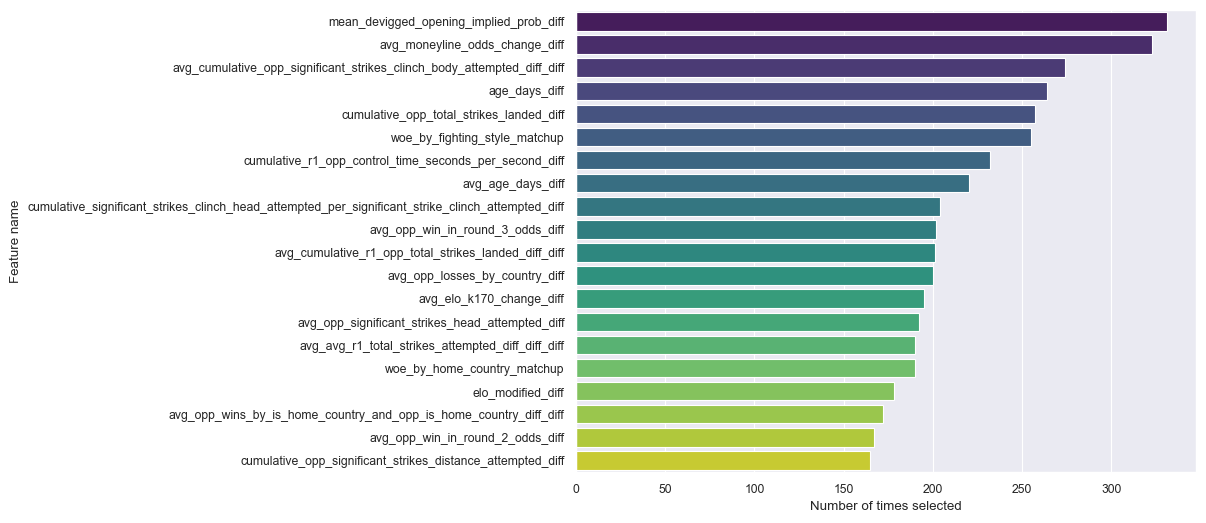

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", context="paper")

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=temp, x="count", y="feature", hue="feature", palette="viridis", ax=ax)
ax.set_xlabel("Number of times selected")
ax.set_ylabel("Feature name")
plt.show()

In [7]:
abs_coefs_df = pd.DataFrame.from_dict(feature_abs_coefs, orient="index").reset_index().rename(columns={"index": "feature"})

# narrow format
abs_coefs_df = pd.melt(abs_coefs_df, id_vars=["feature"], var_name="event_index", value_name="abs_coef")
abs_coefs_df

,feature,event_index,abs_coef
0,avg_knockdowns_scored_diff,0,0.0
1,cumulative_knockdowns_scored_diff,0,0.0
2,avg_knockdowns_scored_per_second_diff,0,0.0
3,cumulative_knockdowns_scored_per_second_diff,0,0.0
4,avg_knockdowns_scored_per_strike_landed_diff,0,0.0
...,...,...,...
1292219,avg_opp_avg_event_occupancy_pct_diff_diff,330,0.0
1292220,avg_opp_event_occupancy_pct_change_diff,330,0.0
1292221,avg_opp_event_occupancy_pct_change_diff_diff,330,0.0
1292222,avg_opp_avg_event_occupancy_pct_change_diff,330,0.0


In [8]:
averages_df = abs_coefs_df.groupby("feature").agg({"abs_coef": "mean"}).reset_index()
averages_df = averages_df.sort_values(by=["abs_coef", "feature"], ascending=[False, True]).reset_index(drop=True)
top_20_names = averages_df.head(20)["feature"].tolist()

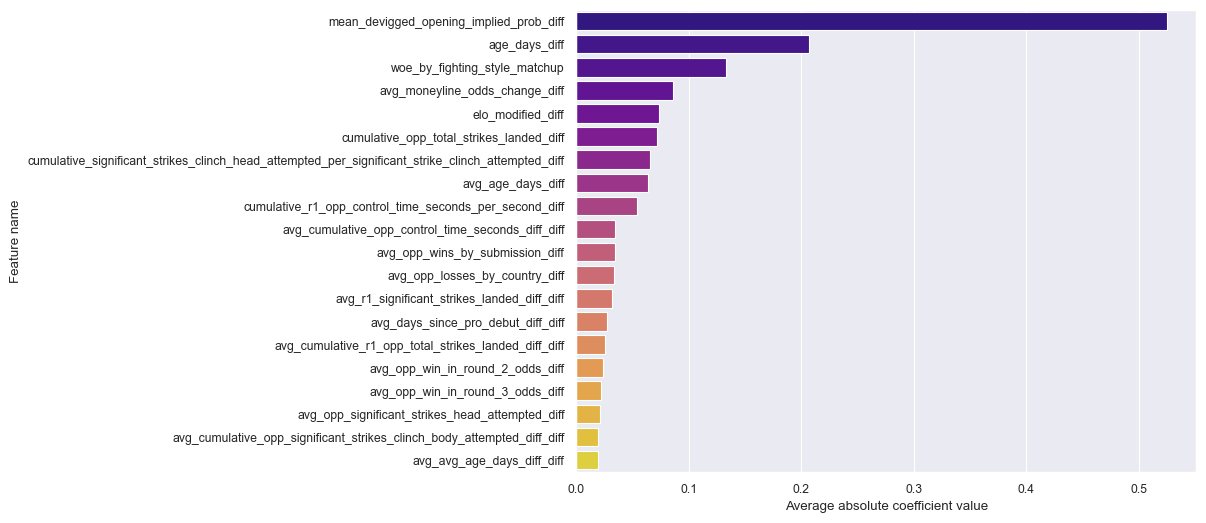

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=averages_df.head(20), x="abs_coef", y="feature", hue="feature", palette="plasma", ax=ax)
ax.set_xlabel("Average absolute coefficient value")
ax.set_ylabel("Feature name")
plt.show()

In [10]:
set(temp["feature"].tolist()) | set(averages_df.head(20)["feature"].tolist())

{'age_days_diff',
 'avg_age_days_diff',
 'avg_avg_age_days_diff_diff',
 'avg_avg_r1_total_strikes_attempted_diff_diff_diff',
 'avg_cumulative_opp_control_time_seconds_diff_diff',
 'avg_cumulative_opp_significant_strikes_clinch_body_attempted_diff_diff',
 'avg_cumulative_r1_opp_total_strikes_landed_diff_diff',
 'avg_days_since_pro_debut_diff_diff',
 'avg_elo_k170_change_diff',
 'avg_moneyline_odds_change_diff',
 'avg_opp_losses_by_country_diff',
 'avg_opp_significant_strikes_head_attempted_diff',
 'avg_opp_win_in_round_2_odds_diff',
 'avg_opp_win_in_round_3_odds_diff',
 'avg_opp_wins_by_is_home_country_and_opp_is_home_country_diff_diff',
 'avg_opp_wins_by_submission_diff',
 'avg_r1_significant_strikes_landed_diff_diff',
 'cumulative_opp_significant_strikes_distance_attempted_diff',
 'cumulative_opp_total_strikes_landed_diff',
 'cumulative_r1_opp_control_time_seconds_per_second_diff',
 'cumulative_significant_strikes_clinch_head_attempted_per_significant_strike_clinch_attempted_diff',
 '

In [11]:
len(set(temp["feature"].tolist()) | set(averages_df.head(20)["feature"].tolist()))

25